In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

sys.path.append("../../Legacy/packages/")

from utilities import *

# Solve the CW equations

In [2]:
import numpy as np
from scipy.special import comb
from scipy.optimize import fsolve

# Parameters
beta = 1.0  # Temperature-related parameter
i = 10  # Number of terms in summation, adjust as needed

# Function to compute p(k)
def p_k_single(k, i, m_hat):
    coeff = comb(i - 1, k)  # Binomial coefficient
    term1 = ((1 + m_hat) / 2) ** k
    term2 = ((1 - m_hat) / 2) ** (i - 1 - k)
    return coeff * term1 * term2

def p_k(i, mhat):
    pk = np.zeros(i)
    for k in range(0, i):
        pk[k] = p_k_single(k, i, mhat)
    return pk

# Self-consistent equation for \hat{m}
def self_consistent_eq(m_hat, beta):
    return m_hat - np.tanh(beta * m_hat)

# Solve for \hat{m}
def solve_m_hat(beta):
    m_hat_initial = 0.5  # Initial guess for \hat{m}
    m_hat_solution = fsolve(self_consistent_eq, m_hat_initial, args=(beta,))
    return m_hat_solution[0]

def solve_Ji(beta, i, m_hat, start_J):
    """Solve for the single Ji (does not depend on the others)"""
    pk = p_k(i, m_hat)
    m_hat_squared = m_hat ** 2

    def J_i_eq(J_i):
        sum = 0
        for k in range(0, i):
            factor = (2 * k - i + 1) / (i - 1)
            sum += pk[k] * factor * np.tanh((2*k-i+1)*J_i)
        return m_hat_squared - sum
    J_i = fsolve(J_i_eq, start_J)[0] 
    return J_i

def solve_allJ(beta, N, m_hat):
    """Solve for all the Ji values"""
    all_J = np.zeros(N-1)
    start_J = 0
    for i in range(2, N+1):
        all_J[i-2] = solve_Ji(beta, i, m_hat, start_J)
        start_J = all_J[i-2]

    return np.array(all_J)


# Main function
def main(beta, N):
    # Step 1: Solve for \hat{m}
    m_hat_solution = solve_m_hat(beta)

    # Step 2: Solve for J_i values using the solved \hat{m}
    J_i_solutions = solve_allJ(beta, N, m_hat_solution)

    return m_hat_solution, J_i_solutions


In [3]:
# Test that things do not break
beta = 2  # Adjust beta as needed
i = 10  # Adjust i as needed

m_hat_solution, J_i_solutions = main(beta, i)
print(m_hat_solution, J_i_solutions/beta)

0.9575040240772688 [0.78433502 0.47606867 0.33526399 0.25311963 0.20254497 0.16861428
 0.14435586 0.12617576 0.11205284]


## Test on $m$ vs $\beta$

In [4]:
#test on the magnetization vs beta

data = []

for beta in np.linspace(0, 2, 3000):
    m_hat_solution, _ = main(beta, i)
    data.append([beta, m_hat_solution])
data = np.array(data)

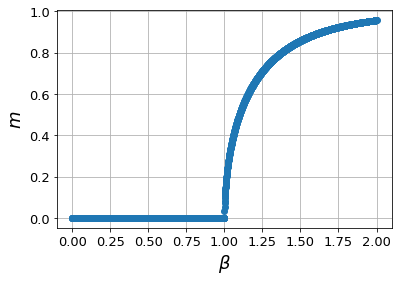

In [5]:
plt.scatter(data[:, 0], data[:, 1], zorder = 3)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$m$")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(r"$\beta$", fontsize=18)
plt.ylabel(r"$m$", fontsize=18)
plt.grid()
plt.show()

## Test on the couplings

In [6]:
#reproduce figure 2a
N = 10  # Adjust i as needed

all_J = []

for beta in np.linspace(1, 2, 100):
    m_hat_solution, J_i_solutions = main(beta, N)
    all_J.append(J_i_solutions/beta)
all_J = np.array(all_J)

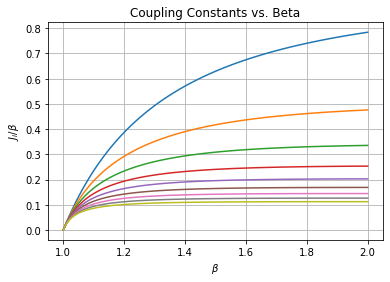

In [7]:
for i in range(N-1):
    plt.plot(np.linspace(1, 2, 100), all_J[:,i])
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$J_i/\beta$")
    plt.title("Coupling Constants vs. Beta")
    plt.grid(True)
plt.show()

## Test sul GS

In [8]:
#reproduce figure 2a
N = 100

all_J = []

betas = np.linspace(0, 5, 100)

for beta in betas:
    m_hat_solution, J_i_solutions = main(beta, N)
    all_J.append(J_i_solutions/beta)
all_J = np.array(all_J)
exponents = np.einsum("ij, j -> ij", all_J, np.arange(1,N))
log_P = -np.log(1+np.exp(-2*exponents)).sum(axis = 1)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

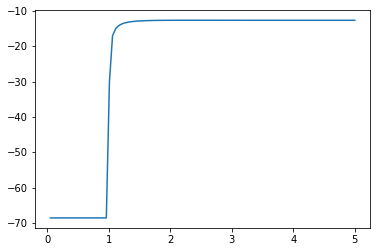

In [9]:
plt.plot(betas, log_P)

In [144]:
def generate_config_CW(J, N, num_config):

    J = torch.tensor(J).to("cuda")

    with torch.no_grad():
        # Initialize a tensor with random binary configurations (values of -1 or 1)
        #config = (torch.bernoulli(torch.full((N_config, N_spins), 0.5)) * 2 - 1).to("cuda")
        #config = torch.ones((N_config, N_spins)).to("cuda")
        #config = (torch.bernoulli(torch.full((num_config, N), 0.5)).to("cuda") * 2 - 1)
        config = torch.ones((num_config, N)).to("cuda")


        # Generate each spin in an autoregressive manner
        for n in range(1, N):
            # Get probabilities from the autoregressive model for the nth spin
            probs = 1/(1+torch.exp(-2*J[n-1] * config[:, :n].sum(1)))  # Sigmoid function
            
            # Sample new spin values based on probabilities and update the configuration
            config[:, n] = (torch.bernoulli(probs) * 2 - 1)
            torch.cuda.empty_cache()
    
    return config
    

In [145]:
energies = []
magnetizations = []
for J in all_J:
    x = generate_config_CW(J, N, 10000)
    m = x.mean(1)
    eg = -m*m/2
    eg = eg.mean()
    energies.append(eg)
    magnetizations.append(m.mean())

NameError: name 'all_J' is not defined

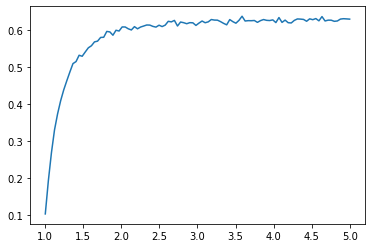

In [209]:
plt.plot(betas, magnetizations)


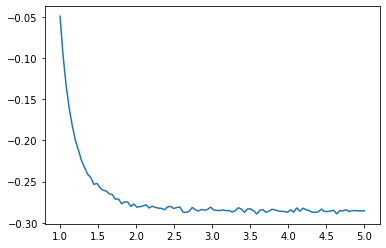

In [210]:
plt.plot(betas, energies)

## Comparison between analytical and simulated times

In [140]:
import math

In [141]:
def comb(n, k):
    if k > n or k < 0:
        return 0
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [142]:
comb_values = [comb(N, k)/2**N for k in k_values]
comb_values = np.array(comb_values)
print(comb_values.sum())

NameError: name 'k_values' is not defined

In [159]:
def gaussian_m(m, N):
    return np.sqrt(2/N/np.pi)*np.exp(-N*m**2/2)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


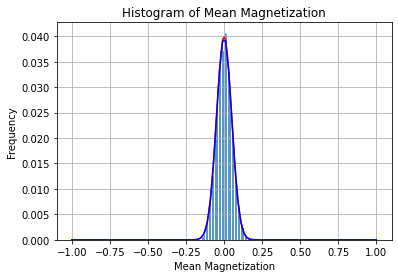

In [169]:
beta = 1.3
N = 400

J = torch.zeros(N-1)
#m_hat_solution, J = main(beta, N)

x = generate_config_CW(J, N, 10000)
plt.hist(x.mean(1).cpu().numpy(), bins=100, alpha=0.75, weights=np.ones_like(x.mean(1).cpu().numpy()) / x.shape[0])

# Plot the comb function
k_values = np.arange(0, N, 2)
comb_values = [comb(N, k)/2**N for k in k_values]
plt.plot(2*k_values/N-1, comb_values, label='Comb(N, k)', color='red')
plt.plot(np.linspace(-1, 1, 100), gaussian_m(np.linspace(-1, 1, 100), N), label='Gaussian', color='blue')
#plt.legend()

plt.xlabel('Mean Magnetization')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnetization')
plt.grid(True)
plt.show()

# Transition times in Metropolis MC

## Transition matrix

In [8]:
def get_transition_matrix(N, beta):
    P = np.zeros((N+1, N+1))

    for i in range(0, N+1):
        m = (2*i-N)/N
        print(m)
        if i != 0:
            P[i, i-1] = (1+m)/2*np.exp(-2*beta*(m-1/N))
        P[i, i] = (1+m)/2*(1-np.exp(-2*beta*(m-1/N)))
        if i != N:
            P[i, i+1] = (1-m)/2
    return P


In [9]:
def get_transition_matrix(N, beta):
    """Get the transition matrix for the system in magnetizations."""
    P = torch.zeros((N+1, N+1))

    for i in range(0, N+1):
        m = (2*i-N)/N
        
        if i != 0:
            P[i, i-1] = (1+m)/2*min(1, np.exp(-2*beta*(m-1/N)))
        P[i, i] = 1 - (1+m)/2*min(1, np.exp(-2*beta*(m-1/N))) - (1-m)/2*min(1, np.exp(2*beta*(m+1/N)))
        if i != N:
            P[i, i+1] = (1-m)/2*min(1, np.exp(2*beta*(m+1/N)))
    return P

In [10]:
N = 10
beta = 1.5

P = get_transition_matrix(N, beta)
target_m = 0.2
target_i = int((target_m+1)*N/2)
Q = torch.cat((P[:target_i], P[target_i+1:]), dim=0)
Q = torch.cat((Q[:, :target_i], Q[:, target_i+1:]), dim=1)
inverse_matrix = torch.inverse(torch.eye(N) - Q.numpy())
torch.einsum("ij, j->i", inverse_matrix,torch.ones(N))

tensor([175.8691, 160.9893, 138.4146, 107.5193,  71.4384,  36.7192,  36.0809,
         66.9762,  89.5509, 104.4307])

## Monte Carlo

In [11]:
def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

### Check on MC

In [12]:
pop_size = 1000
beta = 2
N = 1000
pop = torch.randint(0, 2, (pop_size, N), device = "cuda").float() * 2 - 1
for i in tqdm(range(10000)):
    pop = monte_carlo_update_CW(pop, N, beta)

100%|██████████| 10000/10000 [00:02<00:00, 3765.94it/s]


In [210]:
pop.mean(1).abs().mean()

tensor(0.9564, device='cuda:0')

In [214]:
#test on the magnetization vs beta

data = []
pop_size = 1000

for beta in tqdm(np.linspace(0, 2, 30)):
    pop = torch.randint(0, 2, (pop_size, N), device = "cuda").float() * 2 - 1
    for i in range(10000):
        pop = monte_carlo_update_CW(pop, N, beta)
    data.append([beta, pop.mean(1).abs().mean()])
data = np.array(data)

100%|██████████| 30/30 [01:45<00:00,  3.51s/it]


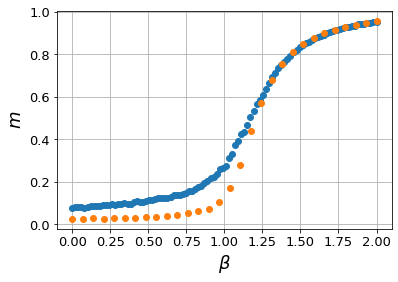

In [215]:
plt.scatter(data2[:, 0], data2[:, 1], zorder = 3)
plt.scatter(data[:, 0], data[:, 1], zorder = 3)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$m$")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(r"$\beta$", fontsize=18)
plt.ylabel(r"$m$", fontsize=18)
plt.grid()
plt.show()

## Comparison first passage times

caso con segno

In [4]:
N = 20
beta = 1.1
M = 10

P = get_transition_matrix(N, beta)
target_m = M/N
target_i = int((target_m+1)*N/2)
Q = torch.cat((P[:target_i], P[target_i+1:]), dim=0)
Q = torch.cat((Q[:, :target_i], Q[:, target_i+1:]), dim=1)
inverse_matrix = torch.inverse(torch.eye(N) - Q.numpy())
torch.einsum("ij, j->i", inverse_matrix,torch.ones(N))[int(N/2)]

NameError: name 'get_transition_matrix' is not defined

In [5]:
import torch

# Parameters
pop_size = 10000  # Size of the population

# Population of spins, randomly initialized to -1 or 1
pop = torch.cat([torch.ones((pop_size, N // 2), device="cuda"), -torch.ones((pop_size, N // 2), device="cuda")], dim=1)


# Array to track the time (iteration count) at which each population member reaches the target magnetization
time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

# Flag to indicate whether each population member has reached the target
reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

# Loop to update the population using the Monte Carlo method
for i in range(1, 10000):  # Maximum number of iterations
    
    # Perform a Monte Carlo update for the entire population
    pop = monte_carlo_update_CW(pop, N, beta)  
    
    # Calculate magnetization for each population member
    magnetizations = pop.mean(1)  
    
    # Check which members have reached the target magnetization (absolute value comparison)
    newly_reached = (magnetizations >= target_m) & ~reached_target
    
    # Update the time for newly reached members (only for the first time they reach the target)
    time_to_target[newly_reached] = i
    
    # Mark members as having reached the target
    reached_target |= newly_reached
    
    # Break if all members of the population have reached the target
    if reached_target.all():
        print("All population members have reached the target magnetization.")
        break

# Print or save the times to target
#print("Time to target for each population member:", time_to_target)
time_to_target.mean()


NameError: name 'target_m' is not defined

caso senza segno

In [13]:
def get_transition_matrix_absm(N, beta):
    """Get the transition matrix for the system in magnetizations."""
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P

In [14]:
def markov_fpt_abs(N, beta, M):
    P = get_transition_matrix_absm(N, beta)
    target_i = int(M/2)
    Q = torch.cat((P[:target_i], P[target_i+1:]), dim=0)
    Q = torch.cat((Q[:, :target_i], Q[:, target_i+1:]), dim=1)
    inverse_matrix = torch.inverse(torch.eye(int(N/2)) - Q.numpy())
    return float(torch.einsum("ij, j->i", inverse_matrix,torch.ones(int(N/2)))[0])

In [7]:
import torch

def montecarlo_fpt_abs(N, beta, target_M, pop_size = 10000):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N // 2), device="cuda"), -torch.ones((pop_size, N // 2), device="cuda")], dim=1)


    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    # Loop to update the population using the Monte Carlo method
    for i in range(1, 10000):  # Maximum number of iterations
        
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  
        
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = i
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target


In [30]:
N = 100
beta = 1.5
M = 90

def compare_abs(N, beta, M):
    analytic_time = markov_fpt_abs(N, beta, M)
    simulated_time = float(montecarlo_fpt_abs(N, beta, M).mean())
    return analytic_time, simulated_time


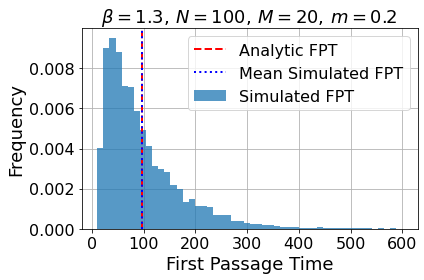

In [31]:
#histogram of the first passage time
N = 100
beta = 1.3
M = 20

analytic_time = markov_fpt_abs(N, beta, M)
fpt = montecarlo_fpt_abs(N, beta, M)
plt.hist(fpt.cpu().numpy(), bins=50, alpha=0.75, label='Simulated FPT', zorder = 3, density = True)
plt.axvline(analytic_time, color='r', linestyle='dashed', linewidth=2, label='Analytic FPT', zorder = 5)
plt.axvline(fpt.mean().item(), color='b', linestyle='dotted', linewidth=2, label='Mean Simulated FPT', zorder = 5)

plt.title(fr'$\beta={beta}, \, N={N}, \, M={M}, \, m = {M/N}$', fontsize=18)

plt.xlabel('First Passage Time', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig('fpt_histogram.png')

In [78]:
#histogram of the first passage time
N = 100
beta = 1.3
data = []

for M in np.arange(2, 90, 4):
    analytic_time, simulated_time = compare_abs(N, beta, M)
    print(M, analytic_time, simulated_time)
    data.append([M, analytic_time, simulated_time])

data = np.array(data)

2 1.0 1.0
6 9.199420928955078 9.244599342346191
10 25.66202163696289 25.65199851989746
14 49.76579284667969 49.72019958496094
18 80.32476806640625 80.4948959350586
22 115.83397674560547 115.31999969482422
26 154.74276733398438 152.4626922607422
30 195.690185546875 194.3675994873047
34 237.6614532470703 238.79058837890625
38 280.05596923828125 279.1365051269531
42 322.6856689453125 322.1092834472656
46 365.73492431640625 367.4898986816406
50 409.7188720703125 406.76739501953125
54 455.46966552734375 454.0957946777344
58 504.1828308105469 506.4740905761719
62 557.5624389648438 561.2965087890625
66 618.1449584960938 619.736083984375
70 689.9852294921875 694.8284912109375
74 780.185546875 778.9884643554688
78 902.67724609375 900.0570068359375
82 1089.081787109375 1096.0401611328125
86 1427.010009765625 1430.26513671875


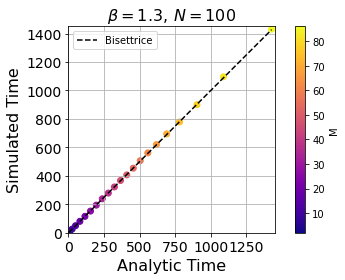

In [79]:
plt.plot([data[:,1].min(), data[:,1].max()], [data[:,1].min(), data[:,1].max()], 'r--', label='Bisettrice', color = "black")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
sc = plt.scatter(data[:,1], data[:,2], c=data[:,0], cmap='plasma')
plt.colorbar(sc, label='M')
plt.title(fr'$\beta={beta}, \, N={N}$', fontsize=16)
plt.xlabel('Analytic Time', fontsize=16)
plt.ylabel('Simulated Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.xlim(0,1450)
plt.ylim(0,1450)

plt.legend()
plt.tight_layout()
plt.savefig('fpt_comparison.png')

In [95]:
from scipy.optimize import curve_fit

def model(x, A, B,C):
    return A*x**B+C

# Extract the x and y data from columns 0 and 2, respectively
x_data = data[:, 0]
y_data = data[:, 2]

# Filter the data to only include points where x < 60
mask = x_data < 60
x_filtered = x_data[mask]
y_filtered = y_data[mask]

# Perform the curve fitting
initial_guess = [1000, 30, 10]  # Initial guess for A and B
params, covariance = curve_fit(model, x_filtered, y_filtered, p0=initial_guess)
print(params, covariance)
# Extract the fitted parameters A and B
A_fit, B_fit, C_fit = params

x_fit = np.linspace(min(x_filtered), max(x_filtered), 500)
y_fit = model(x_fit, A_fit, B_fit, C_fit)

[-9.47301719e-12  3.00000000e+01  7.73987967e+32] [[1.73045993e-18 5.92805390e-15 1.98986108e+19]
 [5.92805390e-15 2.03078814e-11 6.81671648e+22]
 [1.98986108e+19 6.81671648e+22 4.84684919e+82]]


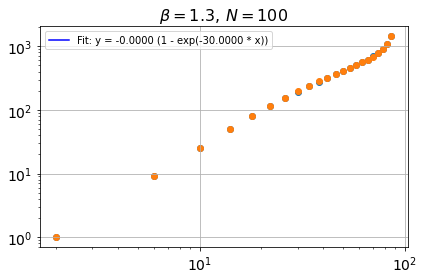

In [91]:
#plt.plot([data[:,1].min(), data[:,1].max()], [data[:,1].min(), data[:,1].max()], 'r--', label='Bisettrice', color = "black")
plt.grid(True)
plt.scatter(data[:,0], data[:,2])
plt.scatter(data[:,0], data[:,1])
plt.title(fr'$\beta={beta}, \, N={N}$', fontsize=16)
plt.plot(x_fit, y_fit, color='blue', label=f'Fit: y = {A_fit:.4f} (1 - exp(-{B_fit:.4f} * x))')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.yscale("log")
plt.xscale("log")

plt.legend()
plt.tight_layout()
plt.show()

## Comparison exact formula tridiagonal matrix

In [86]:
def get_transition_matrix_absm(N, beta):
    """Get the transition matrix for the system in magnetizations."""
    P = torch.zeros((int(N/2)+1, int(N/2)+1))

    for i in range(0, int(N/2)+1):
        m = i*2/N
        if i == 0:
            P[i, 1] = 1
        else: 
            P[i, i-1] = (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N))
            P[i, i] = 1 - (1+np.abs(m))/2*np.exp(-2*beta*(np.abs(m)-1/N)) - (1-np.abs(m))/2
            if i != N/2:
                P[i, i+1] = (1-np.abs(m))/2
    return P
def markov_fpt_abs(N, beta, M):
    P = get_transition_matrix_absm(N, beta)
    target_i = int(M/2)
    #Q = torch.cat((P[:target_i], P[target_i+1:]), dim=0)
    #Q = torch.cat((Q[:, :target_i], Q[:, target_i+1:]), dim=1)
    Q = P[:target_i, :target_i]
    length = Q.shape[0]
    inverse_matrix = torch.inverse(torch.eye(int(length)) - Q)
    return float(torch.einsum("ij, j->i", inverse_matrix,torch.ones(int(length)))[0])

In [8]:
def a(i):
    if i == 1:
        return 1
    return 0.5-(i-1)/N + (0.5+(i-1)/N)*np.exp(-beta/N*(4*i-6))
def b(i):
    if i == 1:
        return -1
    return -(0.5-(i-1)/N)
def c(i):
    return -(0.5+i/N)*np.exp(-beta/N*(4*i-2))

def theta(i):
    if i == 0:
        return 1
    if i == 1:
        return a(i)
    return a(i)*theta(i-1) - c(i-1)*b(i-1)*theta(i-2)

def phi(i):
    if i == nmax+1:
        return 1
    if i == nmax:
        return a(nmax)
    return a(i)*phi(i+1) - c(i)*b(i)*phi(i+2)


In [9]:
def theta_simp(l):
    theta = 1
    for k in range(1, l):
        theta *=(0.5-k/N)
    return theta

In [10]:
from scipy.special import factorial

In [11]:
def theta_factorial(l):
    L = l-1
    return 2/N**(L+1)*factorial(N/2)/factorial(N/2)

In [12]:
N = 100
beta = 1.1
l = 15
nmax = 10
print(theta(l), theta_simp(l))

5.8867042842415e-06 5.88670428424151e-06


In [13]:
def T1j(j):
    el = (-1)**(j+1)
    for k in range(1, j):
        el *= b(k)
    el *= theta(0)*phi(j+1)/theta(nmax)
    return el

In [16]:
sum = 0
for j in range(1, nmax+1):
    sum += T1j(j)
print(sum)
markov_fpt_abs(N, beta, 2*nmax)

NameError: name 'nmax' is not defined

In [40]:
#Thomas method

def thomas_algorithm_from_matrix(A):
    """
    Solves Ax = d where A is a tridiagonal matrix and d is a vector of ones.

    Arguments:
    A -- Tridiagonal matrix (torch tensor of shape (n, n))

    Returns:
    x -- Solution vector
    """
    n = A.shape[0]  # Number of equations

    # Extract the diagonals
    a = torch.zeros(n, dtype=torch.float32)
    b = torch.zeros(n, dtype=torch.float32)
    c = torch.zeros(n, dtype=torch.float32)

    for i in range(n):
        b[i] = A[i, i]  # Main diagonal
        if i > 0:
            a[i] = A[i, i - 1]  # Sub-diagonal
        if i < n - 1:
            c[i] = A[i, i + 1]  # Super-diagonal

    # Right-hand side vector d (all ones)
    d = torch.ones(n, dtype=torch.float32)

    # Temporary storage for modified coefficients
    c_prime = torch.zeros(n, dtype=torch.float32)
    d_prime = torch.zeros(n, dtype=torch.float32)

    # Forward sweep
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i - 1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0  # c[n-1] is unused
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / denom

    # Back substitution
    x = torch.zeros(n, dtype=torch.float32)
    x[-1] = d_prime[-1]

    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]
    

    return x

In [54]:
P = get_transition_matrix_absm(N, beta)[:nmax, :nmax]
thomas_algorithm_from_matrix(torch.eye(P.size(0))-P)

tensor([108.0036, 107.0036, 103.9446,  98.7590,  91.3929,  81.8060,  69.9712,
         55.8737,  39.5089,  20.8809])

In [51]:
N = 100
beta = 1.1
l = 15
nmax = 10
markov_fpt_abs(N, beta, 2*nmax)

tensor([108.0036, 107.0036, 103.9446,  98.7590,  91.3929,  81.8060,  69.9712,
         55.8737,  39.5089,  20.8809])

In [68]:
#time check

N = 100000
beta = 1.1
l = 15
nmax = 10

Q = get_transition_matrix_absm(N, beta)

In [83]:
import time

nmax = 1000
data = []
while nmax <= 32000:
    P = Q[:nmax, :nmax]
    matrix = torch.eye(P.size(0))-P

    start_time = time.time()
    for i in range(10):
        thomas_algorithm_from_matrix(matrix)
    end_time = time.time()
    print(nmax, end_time-start_time)
    data.append([nmax, end_time-start_time])
    nmax *= 2
data = np.array(data)

1000 0.4368476867675781
2000 0.8635950088500977
4000 1.7271041870117188
8000 3.4882285594940186
16000 6.980109214782715
32000 14.139461517333984


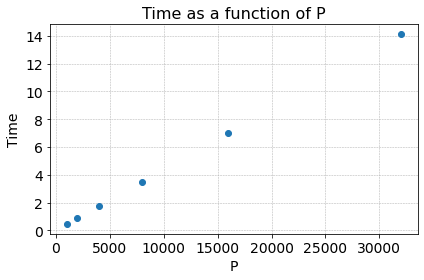

In [84]:
plt.scatter(data[:, 0], data[:, 1], zorder=3)
plt.xlabel('P', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Time as a function of P', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

# Comparison between the methods

In [184]:
N = 500
beta = 2
m_max = 0.6

data = []
for M in np.arange(2, int(N*m_max), int(N*m_max/40)):
    m = M/N
    fpt_metro = markov_fpt_abs(N, beta, M)
    k1 = int(N*(1+m)/2)
    k2 = int(N*(1-m)/2)
    fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
    print(M, fpt_metro, fpt_made)
    data.append([M, fpt_metro, fpt_made])
data = np.array(data)

2 1.0 14.075563971305735
9 15.953352928161621 15.212656271995714
16 61.24980926513672 18.101238305064676
23 109.54999542236328 23.772333603283137
30 184.01788330078125 34.438948954515766
37 241.57199096679688 54.9392200754891
44 314.3962097167969 97.03510853410128
51 363.8736572265625 188.0212814059896
58 422.204833984375 405.56001708992983
65 460.71923828125 954.7468369100064
72 506.4078369140625 2520.0940739222233
79 537.340576171875 7211.905216675028
86 575.2453002929688 23350.15835592261
93 601.7333374023438 81303.30120990315
100 635.06005859375 323780.72039009916
107 658.8541870117188 1373360.7873927217
114 689.2974243164062 6748284.378223456
121 711.3333129882812 34924083.62445429
128 739.8455200195312 212493900.47239345
135 760.6846923828125 1344374484.3194718
142 787.8746337890625 10169512335.32344
149 807.8958740234375 78837503412.30019
156 834.1925659179688 744789802125.7604
163 853.6737670898438 7094608386713.22
170 879.4033203125 112845089980740.56
177 898.5625 987901329415

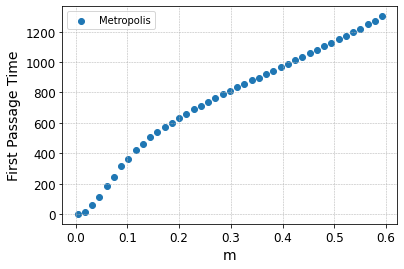

In [185]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")
plt.scatter(data[:,0]/N, data[:,1], label = "Metropolis")

#plt.yscale("log")
#plt.xscale("log")

plt.xlabel('m', fontsize=14)
plt.ylabel('First Passage Time', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend()

In [167]:
N = 500
beta = 1.5
m_max = 0.6
data_all = []
betas = [1.1, 1.2, 1.3, 1.5, 2, 4,6]
for beta in betas:
    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/40)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
        print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_made])
    data_all.append(data)
data_all = np.array(data_all)

2 1.0 14.075563971305735
9 16.11844253540039 15.212656271995714
16 64.83004760742188 18.101238305064676
23 122.73532104492188 23.772333603283137
30 227.8194122314453 34.438948954515766
37 326.76483154296875 54.9392200754891
44 483.9397888183594 97.03510853410128
51 619.4085083007812 188.0212814059896
58 821.2161865234375 405.56001708992983
65 986.7813720703125 954.7468369100064
72 1223.928955078125 2520.0940739222233
79 1412.3458251953125 7211.905216675028
86 1675.1837158203125 23350.15835592261
93 1879.45703125 81303.30120990315
100 2159.276611328125 323780.72039009916
107 2373.50048828125 1373360.7873927217
114 2663.44140625 6748284.378223456
121 2883.31689453125 34924083.62445429
128 3178.843017578125 212493900.47239345
135 3401.8818359375 1344374484.3194718
142 3700.885986328125 10169512335.32344
149 3926.390869140625 78837503412.30019
156 4229.0771484375 744789802125.7604
163 4458.02294921875 7094608386713.22
170 4766.74560546875 112845089980740.56
177 5001.67578125 98790132941530

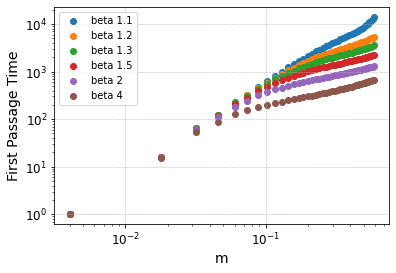

In [179]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")
for n, d in enumerate(data_all[:-1]):
    plt.scatter(d[:,0]/N, d[:,1], label = f"beta {betas[n]}")

plt.yscale("log")
plt.xscale("log")

#plt.ylim(0, 4000)

plt.xlabel('m', fontsize=14)
plt.ylabel('First Passage Time', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend()

In [198]:
beta = 1.5
m_max = 0.6
data_all = []
Ns = [100, 300, 500, 700, 800]
for N in Ns:
    data = []
    for M in np.arange(2, int(N*m_max), int(N*m_max/40)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
        print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_made])
    data_all.append(np.array(data))

2 1.0 6.407901579946
3 1.0 6.598235290241425
4 4.050871849060059 6.8002220848406525
5 4.050871849060059 7.13686674250603
6 9.1548490524292 7.508578552011554
7 9.1548490524292 8.028975085319287
8 16.236356735229492 8.626877485289873
9 16.236356735229492 9.39560914239491
10 25.14871597290039 10.314744819368325
11 25.14871597290039 11.438132869002501
12 35.686344146728516 12.83612688632503
13 35.686344146728516 14.488301634069831
14 47.600929260253906 16.628618920921053
15 47.600929260253906 19.09821579036478
16 60.619781494140625 19.09821579036478
17 60.619781494140625 26.20452864259354
18 74.46427154541016 31.507826105975568
19 74.46427154541016 37.435040917990776
20 88.86670684814453 46.10901381362278
21 88.86670684814453 55.696036487742354
22 103.58413696289062 70.31624606577472
23 103.58413696289062 86.32885655600064
24 118.40826416015625 111.78480143789827
25 118.40826416015625 139.45430674430875
26 133.1713104248047 185.32743396283138
27 133.1713104248047 234.87041135883578
28 147.

No handles with labels found to put in legend.


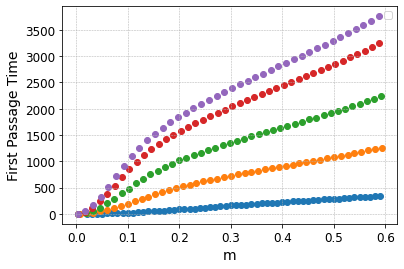

In [200]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")
for n, d in enumerate(data_all):
    plt.scatter(d[:,0]/Ns[n], d[:,1])

#plt.yscale("log")
#plt.xscale("log")

#plt.ylim(0, 4000)

plt.xlabel('m', fontsize=14)
plt.ylabel('First Passage Time', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend()

In [173]:
def gaussian_m(m, N):
    return np.sqrt(2/N/np.pi)*np.exp(-N*m**2/2)

In [344]:
beta = 1.1
m_max_list = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04]

Nvalues = [200, 500, 1000, 2000, 5000, 10000]

all_data = []
for i, N in enumerate(Nvalues):
    data = []
    m_max = m_max_list[i]
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        #fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
        fpt_made = 1/((gaussian_m(m, N) + gaussian_m(-m, N)))
        #print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data = np.array(all_data)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


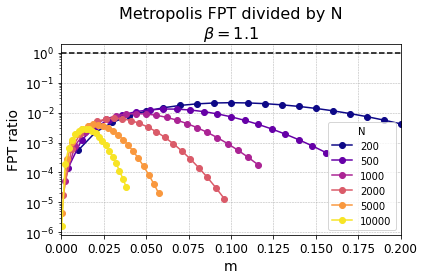

In [345]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[:,2]/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT divided by N\n$\\beta={beta}$", fontsize=16)

plt.tight_layout()
plt.savefig('fpt_ratio_divN.png')

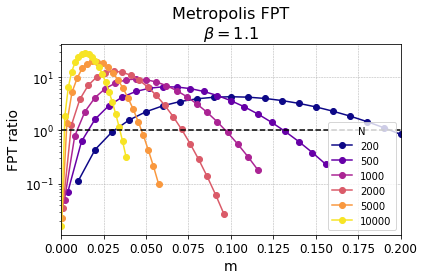

In [210]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[:,2], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
plt.savefig('fpt_ratio.png')


In [ ]:
1/((comb(N, k1) + comb(N, k2))/2**N)

In [223]:
np.arange(1, N+1, 2)/N

array([1.000e-04, 3.000e-04, 5.000e-04, ..., 9.995e-01, 9.997e-01,
       9.999e-01])

In [296]:
def gaussian_m(m, N):
    return np.sqrt(2/N/np.pi)*np.exp(-N*m**2/2)

def markov_fpt_abs_reweight(N, beta, M):
    P = get_transition_matrix_absm(N, beta)
    target_i = int(M/2)
    Q = torch.cat((P[:target_i], P[target_i+1:]), dim=0)
    Q = torch.cat((Q[:, :target_i], Q[:, target_i+1:]), dim=1)
    inverse_matrix = torch.inverse(torch.eye(int(N/2)) - Q.numpy())
    times_tensor = torch.einsum("ij, j->i", inverse_matrix,torch.ones(int(N/2)))
    times_tensor = torch.cat((times_tensor[:target_i], torch.tensor([0]), times_tensor[target_i:]))
    gaussians = gaussian_m(np.arange(0, N+1, 2)/N, N)*2
    gaussians[0] = gaussian_m(0, N)
    times_tensor *= gaussians
    return float(times_tensor[:target_i].mean())


In [297]:
N = 200
beta = 1.1
M = 2
print(markov_fpt_abs_reweight(N, beta, M))
print(markov_fpt_abs(N, beta, M))


0.05641895835477563
1.0


In [ ]:
N = 10000
beta = 1.1
m_max_list = [0.24, 0.16, 0.12, 0.1, 0.06, 0.04]

Nvalues = [200, 500, 1000, 2000, 5000, 10000]

all_data = []
for i, N in enumerate(Nvalues):
    data = []
    m_max = m_max_list[i]
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        fpt_metro_rew = markov_fpt_abs_reweight(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
        #fpt_made = 1/((gaussian_m(m, N) + gaussian_m(-m, N)))
        #print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_metro_rew, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data = np.array(all_data)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [334]:
N = 10000
beta = 1.1
m_max_list = [0.24, 0.16, 0.12, 0.1, 0.068, 0.048]

Nvalues = [200, 500, 1000, 2000, 5000, 10000]

all_data = []
for i, N in enumerate(Nvalues):
    data = []
    m_max = m_max_list[i]
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        fpt_metro_rew = markov_fpt_abs_reweight(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        fpt_made = 0
        for k in range(0, k2+1):
            fpt_made += gaussian_m(2*k/N-1, N)
        for k in range(k1, N+1):
            fpt_made += gaussian_m(2*k/N-1, N)
        fpt_made = 1/fpt_made
        #fpt_made = 1/((gaussian_m(m, N) + gaussian_m(-m, N)))
        #print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_metro_rew, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data = np.array(all_data)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


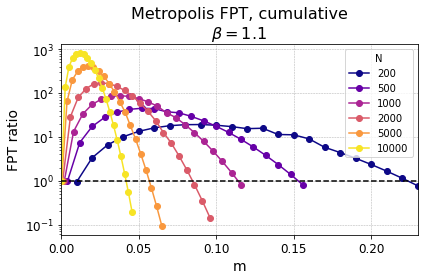

In [335]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[:,3], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.23)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT, cumulative\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
plt.savefig('fpt_ratio_cumulative.png')


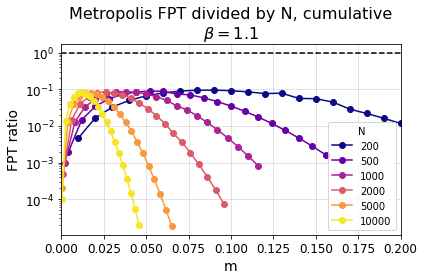

In [336]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[:,3]/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT divided by N, cumulative\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
plt.savefig('fpt_ratio_divN_cumulative.png')


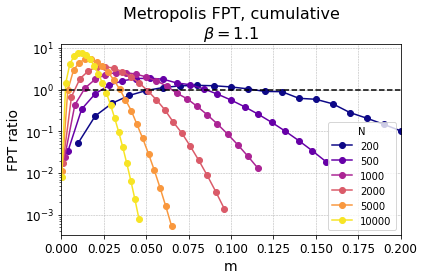

In [340]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,2]/d[:,3], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT, cumulative\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
plt.savefig('fpt_ratio_cumulative_average.png')


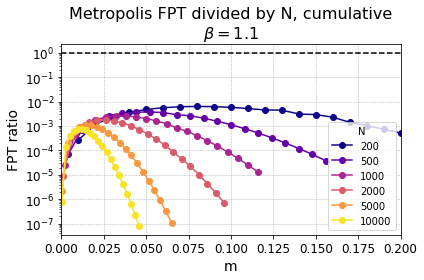

In [338]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,2]/d[:,3]/Nvalues[i], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(title="N")
plt.title(f"Metropolis FPT divided by N, cumulative\n$\\beta={beta}$", fontsize=16)
plt.tight_layout()
plt.savefig('fpt_ratio_cumulative_average_divN.png')


In [183]:
N = 10000
beta = 1.1

Nvalues = [200, 500, 1000, 2000, 5000, 10000]

m_max_list = [0.50]*len(Nvalues)

all_data = []
for i, N in enumerate(Nvalues):
    data = []
    m_max = m_max_list[i]
    for M in np.arange(2, int(N*m_max), int(N*m_max/20)):
        m = M/N
        fpt_metro = markov_fpt_abs(N, beta, M)
        k1 = int(N*(1+m)/2)
        k2 = int(N*(1-m)/2)
        #fpt_made = 1/((comb(N, k1) + comb(N, k2))/2**N)
        fpt_made = 1/((gaussian_m(m, N) + gaussian_m(-m, N)))
        #print(M, fpt_metro, fpt_made)
        data.append([M, fpt_metro, fpt_made])
    data = np.array(data)
    all_data.append(data)
all_data = np.array(all_data)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


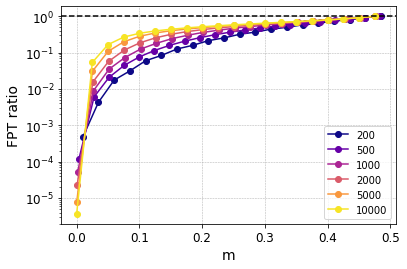

In [186]:
#plt.scatter(data[:,0]/N, data[:,2], label = "Made")

colors = plt.cm.plasma(np.linspace(0, 0.95, len(all_data)))

for i, (d, color) in enumerate(zip(all_data, colors)):
    plt.plot(d[:,0]/Nvalues[i], d[:,1]/d[-1,1], marker='o', label=f"{Nvalues[i]}", color=color)

plt.axhline(y=1, color='black', linestyle='--')
plt.yscale("log")
#plt.ylim(10**(-2), 10**2)
#plt.xlim(0, 0.20)
plt.xlabel('m', fontsize=14)
plt.ylabel('FPT ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend()